In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

import shutil

# Define original Drive paths
train_dir_drive = "/content/drive/MyDrive/Brain_Tumor_MRI/train-20250724T113747Z-1-001/train"
val_dir_drive   = "/content/drive/MyDrive/Brain_Tumor_MRI/valid-20250724T113750Z-1-001/valid"
test_dir_drive  = "/content/drive/MyDrive/Brain_Tumor_MRI/test-20250724T113741Z-1-001/test"

# Define destination in Colab local storage
train_dir = "/content/brain_tumor_dataset/train"
val_dir   = "/content/brain_tumor_dataset/valid"
test_dir  = "/content/brain_tumor_dataset/test"

# Copy from Drive to local (only once)
shutil.copytree(train_dir_drive, train_dir)
shutil.copytree(val_dir_drive, val_dir)
shutil.copytree(test_dir_drive, test_dir)


'/content/brain_tumor_dataset/test'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)     # Smaller size for performance
BATCH_SIZE = 16           # Small batch for better memory usage

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=False,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Validation and Test data generators (no augmentation, just rescale)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.05
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load base model without top layers
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base model

# Build the full model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 output classes
])



In [ ]:
base_model.trainable = False


In [ ]:

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=20,
                    callbacks=[early_stop])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 28s 196ms/step - accuracy: 0.3832 - loss: 1.5889 - val_accuracy: 0.7271 - val_loss: 0.7675
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 0.6595 - loss: 0.8571 - val_accuracy: 0.7849 - val_loss: 0.5890
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.7345 - loss: 0.6760 - val_accuracy: 0.8187 - val_loss: 0.5380
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.7569 - loss: 0.6169 - val_accuracy: 0.8247 - val_loss: 0.4961
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 0.8089 - loss: 0.5300 - val_accuracy: 0.8327 - val_loss: 0.4745
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 0.8019 - loss: 0.5326 - val_accuracy: 0.8625 - val_loss: 0.4231
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.8270 - loss: 0.4790 - val_accuracy: 0.8506 - val_loss: 0.4129
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.8309 - loss: 0

In [ ]:
# Unfreeze a portion or all of the base model
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze all except the last 30 layers
    layer.trainable = False


In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-5),  # Lower LR for fine-tuning!
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.fit(train_data, validation_data=val_data, epochs=5, callbacks=[early_stop])


Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 38s 221ms/step - accuracy: 0.3532 - loss: 2.1778 - val_accuracy: 0.8566 - val_loss: 0.4052
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.6581 - loss: 0.9527 - val_accuracy: 0.8307 - val_loss: 0.4477
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.7403 - loss: 0.7240 - val_accuracy: 0.8386 - val_loss: 0.4536
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.7958 - loss: 0.5876 - val_accuracy: 0.8347 - val_loss: 0.4325


In [ ]:
  loss, acc = model.evaluate(test_data)
print(f"Test Accuracy: {acc:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8700 - loss: 0.4089
Test Accuracy: 0.8496


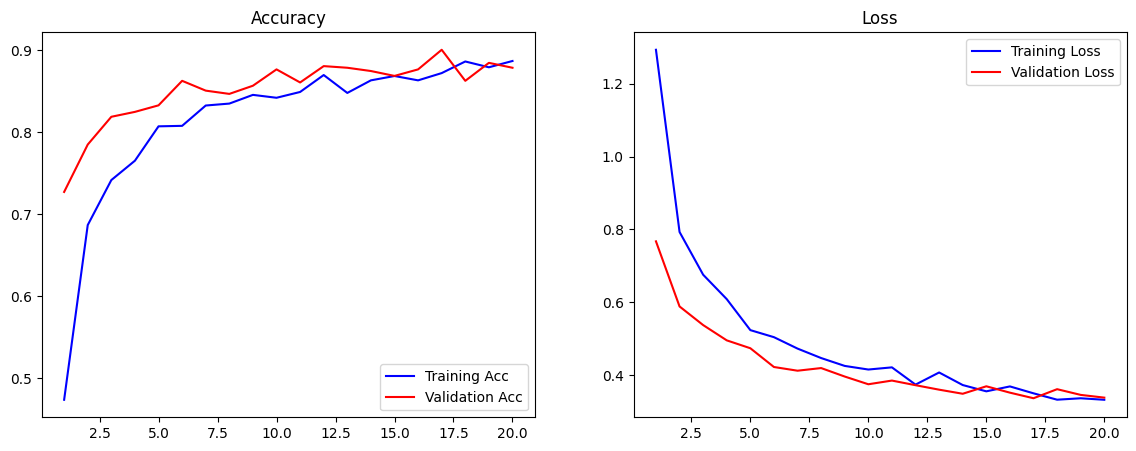

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Acc')
    plt.plot(epochs, val_acc, 'r-', label='Validation Acc')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_history(history)


In [ ]:
model.save('brain_mri_model.h5')
